In [1]:

!pip install yfinance pandas numpy scikit-learn matplotlib seaborn umap-learn

In [49]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

try:
    import umap
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False

In [50]:
#From Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0"}
resp = requests.get(url, headers=headers)
tables = pd.read_html(resp.text)
sp500 = tables[0]

# Ticker（Yahoo format：BRK.B → BRK-B）
sp500["Symbol"] = sp500["Symbol"].astype(str).str.replace(".", "-", regex=False)
tickers = sp500["Symbol"].tolist()
sectors = dict(zip(sp500["Symbol"], sp500["GICS Sector"]))

print("Number of Tickers:", len(tickers))
print("10 exambles:", tickers[:10])

Number of Tickers: 503
10 exambles: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


/tmp/ipython-input-3505351312.py:5: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text)


In [51]:
#daily prices for the last 10 years (500 companies)
dl = yf.download(tickers[:500], start="2015-01-01", end="2024-12-31", auto_adjust=False, progress=False)

# If dl contains multiple tickers, its columns are a MultiIndex
#   (level 0: ['Adj Close', 'Close', ...], level 1: each ticker)
# If it's a single ticker, dl is a regular DataFrame — handle both cases
if isinstance(dl.columns, pd.MultiIndex):
    data = dl["Adj Close"].copy()  # shape: dates x tickers
else:
    # Single-ticker case: if there is a column 'Adj Close', use it
    if "Adj Close" in dl.columns:
        data = dl[["Adj Close"]].rename(columns={"Adj Close": tickers[0]})
    else:
        raise ValueError("Downloaded data does not contain 'Adj Close'.")

data = data.sort_index()
data.head()

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WSM,WST,WTW,WY,WYNN,XEL,XOM,XYL,XYZ,YUM
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,37.120945,24.261042,42.091412,NaN,36.418652,18.539352,74.252632,72.339996,44.511139,37.980820,...,28.977734,49.777264,100.005196,23.727816,126.267166,25.736320,58.423477,33.243156,NaN,42.418289
2015-01-05,36.425396,23.577572,41.299297,NaN,36.426785,18.428413,72.998917,71.980003,43.701717,36.666599,...,28.838367,49.090153,99.286873,23.727816,124.118149,25.444187,56.824902,31.174183,NaN,41.556442
2015-01-06,35.857964,23.579790,41.094891,NaN,36.013123,18.469618,72.472366,70.529999,42.675877,35.943783,...,28.702868,48.250355,98.793022,23.701530,121.470581,25.579576,56.522808,30.990856,NaN,41.046371
2015-01-07,36.333881,23.910437,42.755802,NaN,36.305111,18.577387,73.993523,71.110001,43.124683,36.484070,...,29.748148,49.032875,100.207260,23.773825,125.037903,25.800449,57.095531,31.235294,NaN,42.406567
2015-01-08,37.422958,24.829134,43.202961,NaN,37.051334,18.900694,75.121849,72.919998,43.886040,35.951069,...,30.143030,49.996750,101.352097,24.030085,126.542274,26.099712,58.045872,31.470989,NaN,43.145306


In [52]:
# Daily returns
returns = data.pct_change()

# Mean return and volatility
features = pd.DataFrame({
    "mean_return": returns.mean(skipna=True),
    "volatility": returns.std(skipna=True),
})

# Correlation with the market (equal-weighted average of all returns)
market = returns.mean(axis=1, skipna=True)
features["corr_market"] = returns.corrwith(market)

features.head()

,mean_return,volatility,corr_market
Ticker,,,
A,0.000649,0.016739,0.679320
AAPL,0.001091,0.017932,0.640860
ABBV,0.000698,0.016794,0.442879
ABNB,0.000384,0.030866,0.524813
ABT,0.000553,0.014862,0.612875


In [54]:
fundamentals = []
for t in data.columns:  # Limit to tickers that were successfully downloaded
    try:
        info = yf.Ticker(t).info
        fundamentals.append({
            "ticker": t,
            "pe": info.get("trailingPE"),
            "eps": info.get("trailingEps"),
            "market_cap": info.get("marketCap"),
            "dividend_yield": info.get("dividendYield"),
        })
    except Exception:
        fundamentals.append({
            "ticker": t,
            "pe": np.nan,
            "eps": np.nan,
            "market_cap": np.nan,
            "dividend_yield": np.nan,
        })
    time.sleep(0.2)  # Gentle rate limit to avoid API throttling

fund_df = pd.DataFrame(fundamentals).set_index("ticker")
fund_df.head()

,pe,eps,market_cap,dividend_yield
ticker,,,,
A,32.967290,4.28,40001908736,0.70
AAPL,37.606384,6.58,3672254447616,0.42
ABBV,107.521330,2.11,400779051008,2.89
ABNB,29.755447,4.13,75237638144,NaN
ABT,16.013802,7.97,222134779904,1.85


In [58]:
# The index of 'features' is expected to be the ticker symbol
# (since returns.mean() and similar methods return column names as tickers)
X = features.join(fund_df, how="inner").dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Final feature matrix shape:", X_scaled.shape)

Final feature matrix shape: (390, 7)


In [59]:
X

,mean_return,volatility,corr_market,pe,eps,market_cap,dividend_yield
Ticker,,,,,,,
A,0.000649,0.016739,0.679320,32.967290,4.28,40001908736,0.70
AAPL,0.001091,0.017932,0.640860,37.606384,6.58,3672254447616,0.42
ABBV,0.000698,0.016794,0.442879,107.521330,2.11,400779051008,2.89
ABT,0.000553,0.014862,0.612875,16.013802,7.97,222134779904,1.85
ACN,0.000737,0.015678,0.741106,19.260906,12.15,145124900864,2.79
...,...,...,...,...,...,...,...
WYNN,0.000326,0.031128,0.561775,34.295856,3.38,12052959232,0.86
XEL,0.000462,0.013474,0.469512,22.465374,3.61,47964663808,2.81
XOM,0.000378,0.017505,0.608688,15.715909,7.04,471685660672,3.58


In [60]:
# === Automatic K selection (KMeans) ===

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def sweep_kmeans_auto_k(X_scaled, k_min=2, k_max=10, random_state=42, n_init=10, verbose=True):
    """
    Sweep through K values from k_min to k_max and compute internal validation metrics.
    Returns:
      - results_df: metrics for each K (Silhouette / DBI / CHI)
      - best_k: selected optimal K
      - best_labels: cluster assignments for best_k
      - best_model: trained KMeans model

    Selection rule:
      Maximize Silhouette → if tied, minimize DBI → if still tied, maximize CHI.
    """
    n = X_scaled.shape[0]
    if n < 3:
        raise ValueError("Too few samples (<3).")

    rows = []
    best_tuple = None
    best = {"k": None, "labels": None, "model": None}

    for k in range(k_min, min(k_max, n-1) + 1):  # K cannot exceed n-1
        try:
            km = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
            labels = km.fit_predict(X_scaled)

            sil = silhouette_score(X_scaled, labels)
            dbi = davies_bouldin_score(X_scaled, labels)
            chi = calinski_harabasz_score(X_scaled, labels)

            rows.append({"k": k, "silhouette": sil, "davies_bouldin": dbi, "calinski_harabasz": chi})

            # Selection tuple (higher is better; DBI is inverted)
            pick_tuple = (sil, -dbi, chi)
            if (best_tuple is None) or (pick_tuple > best_tuple):
                best_tuple = pick_tuple
                best = {"k": k, "labels": labels, "model": km}
            if verbose:
                print(f"K={k:2d} | Sil={sil: .3f}  DBI={dbi: .3f}  CHI={chi: .1f}")
        except Exception as e:
            if verbose:
                print(f"K={k}: skipped ({e})")

    results_df = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
    return results_df, best["k"], best["labels"], best["model"]

K= 2 | Sil= 0.204  DBI= 1.769  CHI= 67.5
K= 3 | Sil= 0.202  DBI= 1.202  CHI= 73.5
K= 4 | Sil= 0.230  DBI= 1.127  CHI= 79.2
K= 5 | Sil= 0.231  DBI= 1.059  CHI= 91.2
K= 6 | Sil= 0.235  DBI= 1.012  CHI= 90.1
K= 7 | Sil= 0.242  DBI= 0.878  CHI= 97.7
K= 8 | Sil= 0.241  DBI= 0.950  CHI= 96.9
K= 9 | Sil= 0.252  DBI= 0.938  CHI= 100.2
K=10 | Sil= 0.247  DBI= 0.891  CHI= 102.7

=== Selected K ===
Best K: 9


,k,silhouette,davies_bouldin,calinski_harabasz
0,2,0.203703,1.769364,67.520065
1,3,0.202012,1.201609,73.460230
2,4,0.229975,1.126957,79.163628
3,5,0.230956,1.058904,91.216735
4,6,0.235092,1.011685,90.068870
5,7,0.242012,0.878118,97.694495
6,8,0.240639,0.950445,96.878248
7,9,0.252040,0.938099,100.162383
8,10,0.247196,0.890858,102.726907


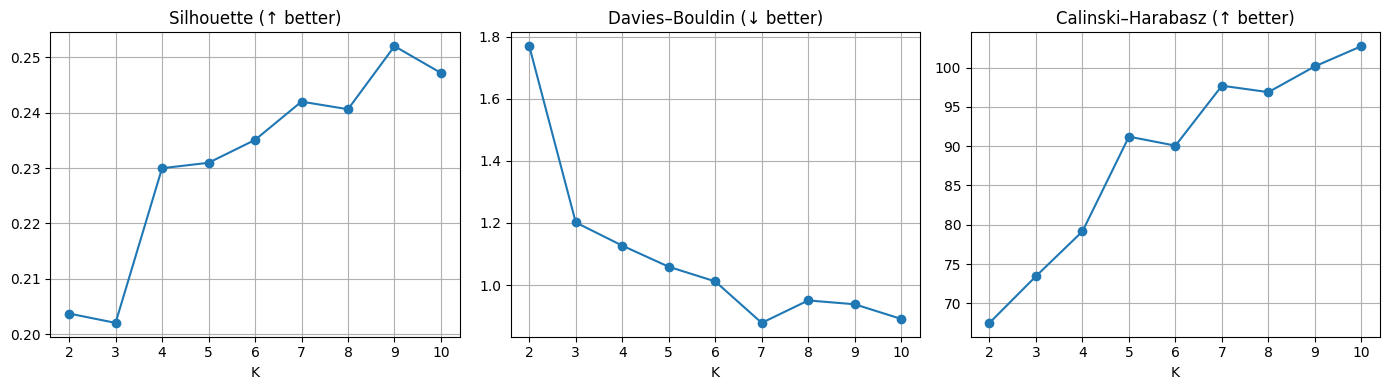

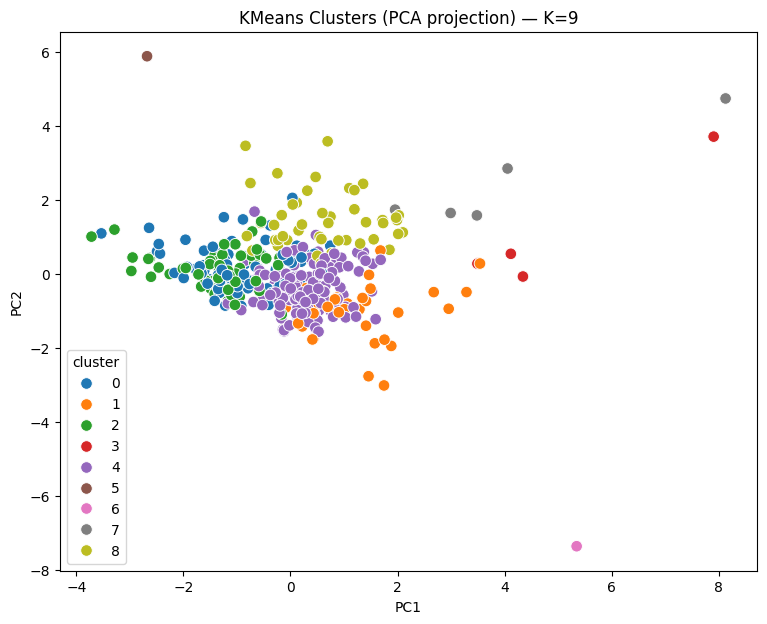

Silhouette: 0.25203958789044045
Davies–Bouldin: 0.9380992087679334
Calinski–Harabasz: 100.16238313272062


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


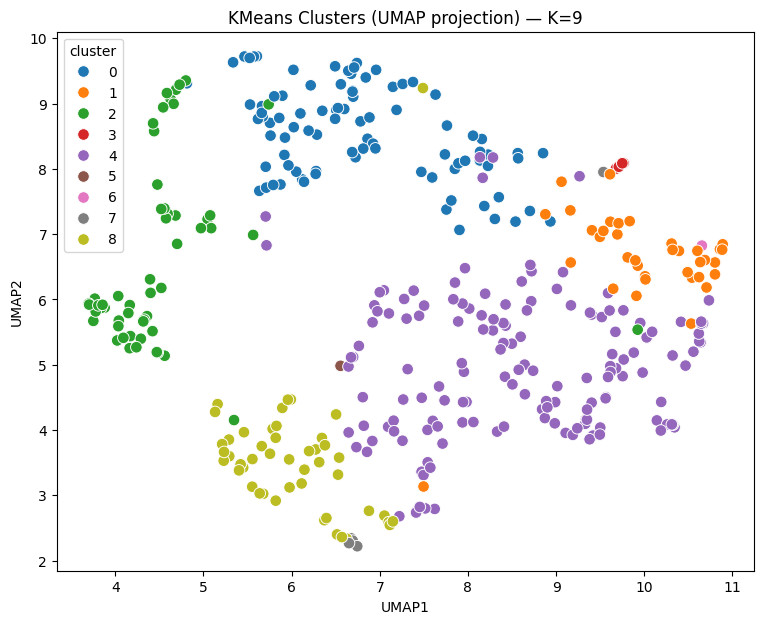

In [61]:
# Parameters (modify if needed)
K_MIN, K_MAX = 2, 10

# Run K sweep
results_df, best_k, best_labels, best_model = sweep_kmeans_auto_k(
    X_scaled, k_min=K_MIN, k_max=K_MAX, random_state=42, n_init=10, verbose=True
)

print("\n=== Selected K ===")
print("Best K:", best_k)

# Display results table
display(results_df)

# Plot metric trends (optional)
fig, axes = plt.subplots(1, 3, figsize=(14,4))
axes[0].plot(results_df["k"], results_df["silhouette"], marker="o")
axes[0].set_title("Silhouette (↑ better)"); axes[0].set_xlabel("K"); axes[0].grid(True)

axes[1].plot(results_df["k"], results_df["davies_bouldin"], marker="o")
axes[1].set_title("Davies–Bouldin (↓ better)"); axes[1].set_xlabel("K"); axes[1].grid(True)

axes[2].plot(results_df["k"], results_df["calinski_harabasz"], marker="o")
axes[2].set_title("Calinski–Harabasz (↑ better)"); axes[2].set_xlabel("K"); axes[2].grid(True)

plt.tight_layout(); plt.show()

# --- Apply results to further analysis ---
# Add cluster labels to X
X["cluster"] = best_labels

# Optionally, add sector/sub-industry information (if available in sp500)
if "GICS Sector" in sp500.columns:
    sector_map = dict(zip(sp500["Symbol"], sp500["GICS Sector"]))
    X["sector"] = X.index.map(lambda t: sector_map.get(t, "Unknown"))

# Visualization (PCA / UMAP)
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)
X["PC1"], X["PC2"] = coords[:,0], coords[:,1]

plt.figure(figsize=(9,7))
sns.scatterplot(data=X, x="PC1", y="PC2", hue="cluster", palette="tab10", s=70)
plt.title(f"KMeans Clusters (PCA projection) — K={best_k}")
plt.show()

# To color by Industry/Sector instead, uncomment the line below:
# sns.scatterplot(data=X, x="PC1", y="PC2", hue="sector", palette="tab20", s=70)

# Evaluation for the selected K
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
print("Silhouette:", silhouette_score(X_scaled, best_labels))
print("Davies–Bouldin:", davies_bouldin_score(X_scaled, best_labels))
print("Calinski–Harabasz:", calinski_harabasz_score(X_scaled, best_labels))

# Optional: UMAP visualization
if 'HAS_UMAP' in globals() and HAS_UMAP:
    reducer = umap.UMAP(random_state=42)
    umap_coords = reducer.fit_transform(X_scaled)
    X["UMAP1"], X["UMAP2"] = umap_coords[:,0], umap_coords[:,1]
    plt.figure(figsize=(9,7))
    sns.scatterplot(data=X, x="UMAP1", y="UMAP2", hue="cluster", palette="tab10", s=70)
    plt.title(f"KMeans Clusters (UMAP projection) — K={best_k}")
    plt.show()

In [62]:
# KMeans clustering with fixed number of clusters (K=9)
kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)
X["cluster"] = labels

# Evaluation metrics
print("Silhouette:", silhouette_score(X_scaled, labels))
print("Davies-Bouldin:", davies_bouldin_score(X_scaled, labels))
print("Calinski-Harabasz:", calinski_harabasz_score(X_scaled, labels))







Silhouette: 0.25203958789044045
Davies-Bouldin: 0.9380992087679334
Calinski-Harabasz: 100.16238313272062


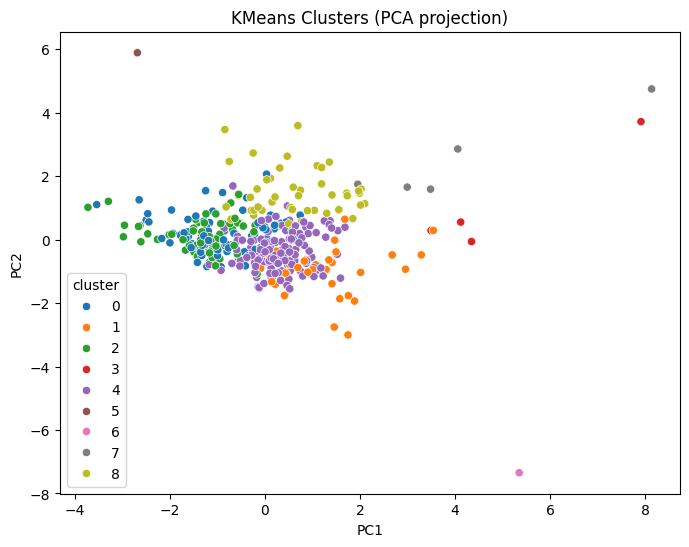

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


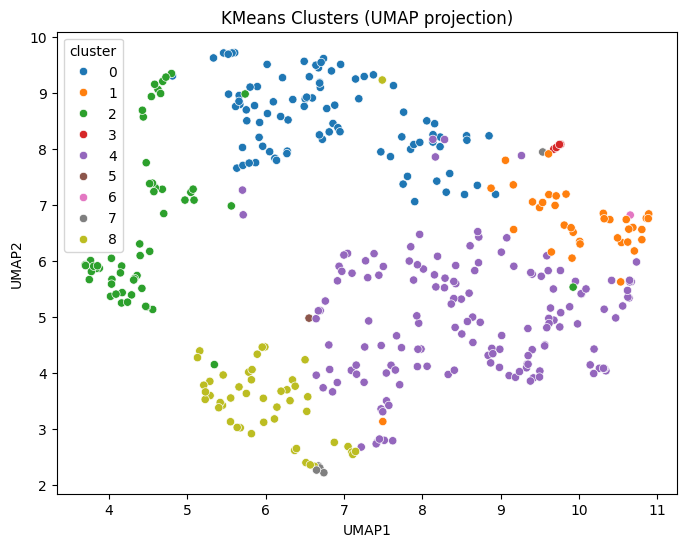

In [63]:
# PCA
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)
X["PC1"], X["PC2"] = coords[:,0], coords[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=X, x="PC1", y="PC2", hue="cluster", palette="tab10")
plt.title("KMeans Clusters (PCA projection)")
plt.show()

# UMAP (if installed)
if HAS_UMAP:
    reducer = umap.UMAP(random_state=42)
    umap_coords = reducer.fit_transform(X_scaled)
    X["UMAP1"], X["UMAP2"] = umap_coords[:,0], umap_coords[:,1]

    plt.figure(figsize=(8,6))
    sns.scatterplot(data=X, x="UMAP1", y="UMAP2", hue="cluster", palette="tab10")
    plt.title("KMeans Clusters (UMAP projection)")
    plt.show()
else:
    print("UMAP not found — skipping visualization.")

In [65]:
# Run KMeans again with fixed number of clusters (K=9)
kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Assign cluster labels to X (before visualization)
X["cluster"] = labels

In [66]:
# Create dictionaries to map tickers to their Sector and Sub-Industry
sector_map = dict(zip(sp500["Symbol"], sp500["GICS Sector"]))
subind_map = dict(zip(sp500["Symbol"], sp500["GICS Sub-Industry"]))

# The index of X corresponds to the ticker symbols
X["sector"] = X.index.map(lambda t: sector_map.get(t, "Unknown"))
X["sub_industry"] = X.index.map(lambda t: subind_map.get(t, "Unknown"))


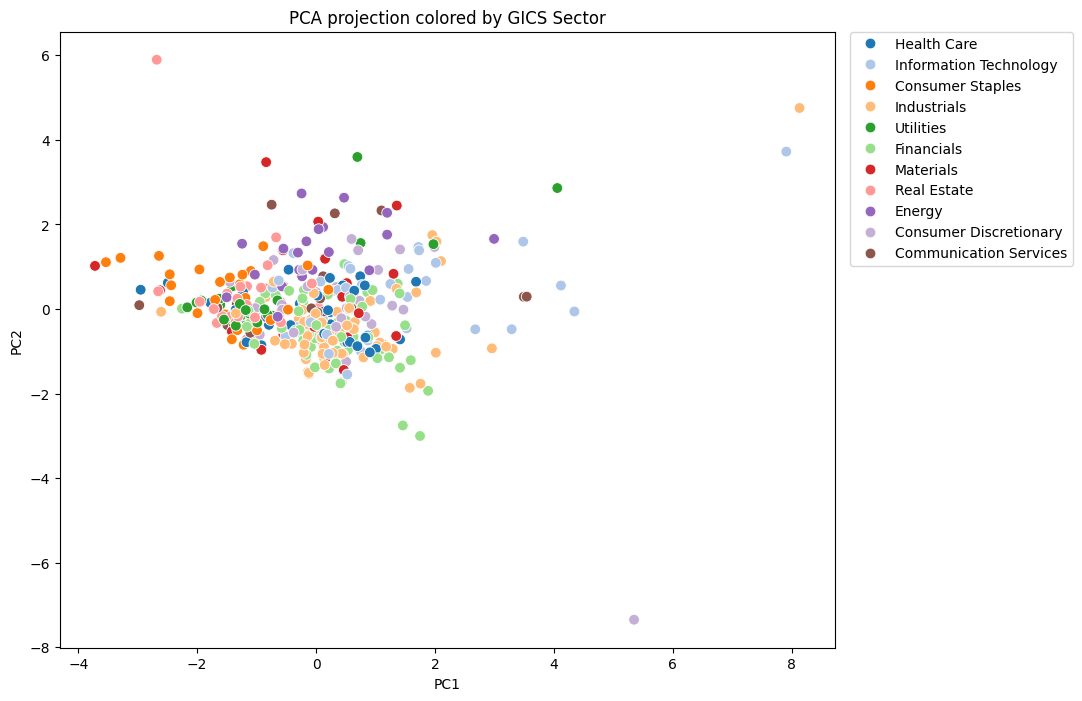

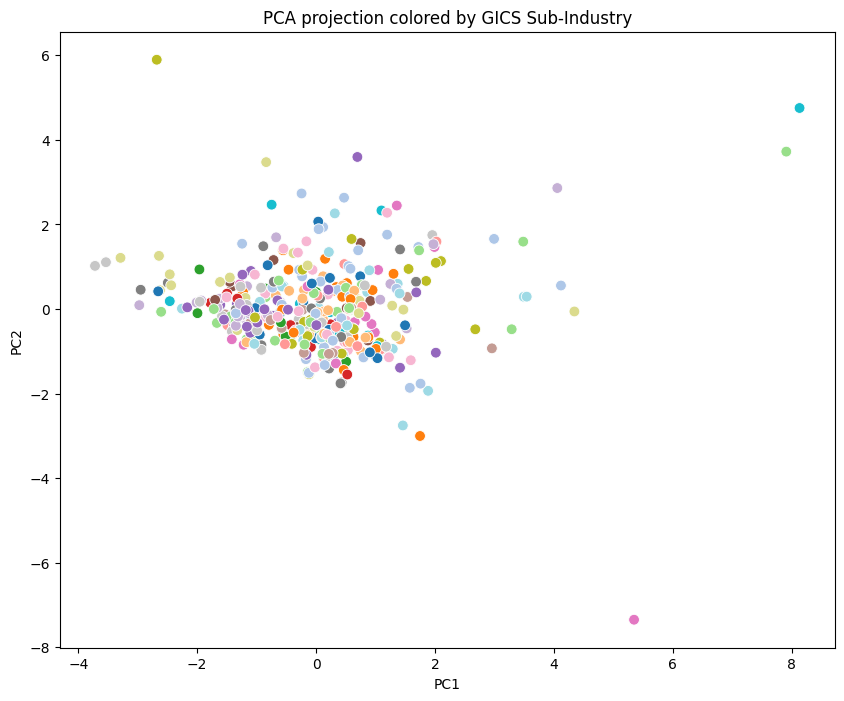

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


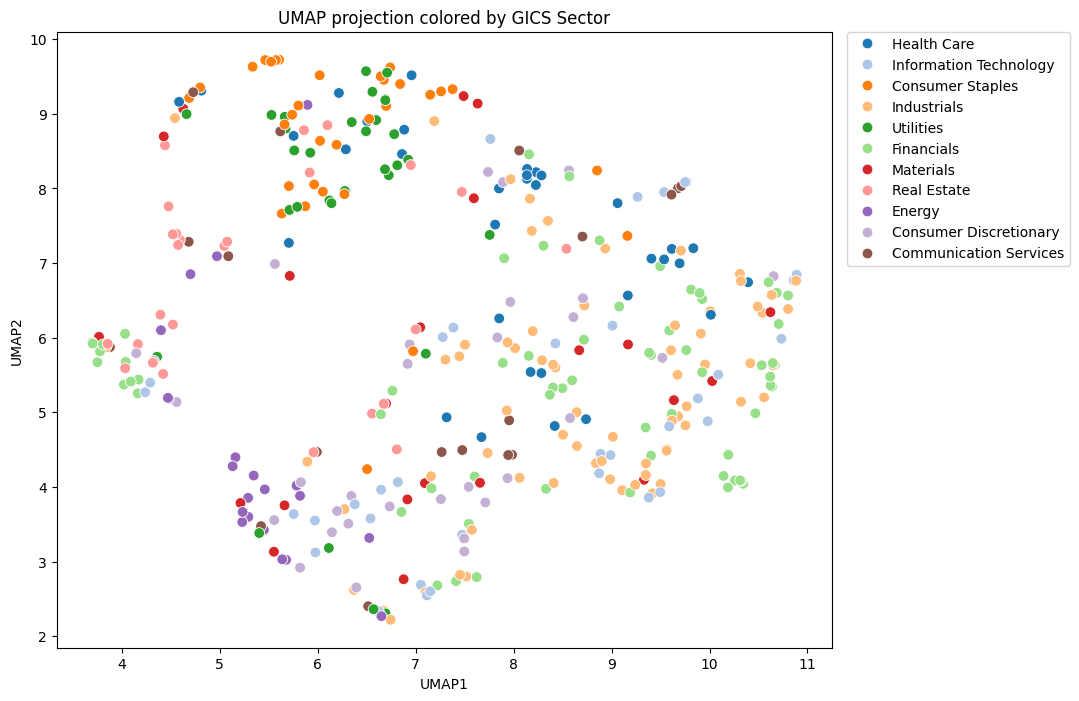

In [67]:
# PCA 2D coordinates
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)
X["PC1"], X["PC2"] = coords[:,0], coords[:,1]

# (a) Color by Sector (11 categories, easy to interpret)
plt.figure(figsize=(10,8))
sns.scatterplot(data=X, x="PC1", y="PC2", hue="sector", palette="tab20", s=60)
plt.title("PCA projection colored by GICS Sector")
plt.legend(loc="best", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.show()

# (b) Color by Sub-Industry (many categories, legend turned off for clarity)
plt.figure(figsize=(10,8))
sns.scatterplot(data=X, x="PC1", y="PC2", hue="sub_industry", palette="tab20", s=60, legend=False)
plt.title("PCA projection colored by GICS Sub-Industry")
plt.show()

# (Optional) UMAP visualization colored by Sector
if HAS_UMAP:
    reducer = umap.UMAP(random_state=42)
    umap_coords = reducer.fit_transform(X_scaled)
    X["UMAP1"], X["UMAP2"] = umap_coords[:,0], umap_coords[:,1]

    plt.figure(figsize=(10,8))
    sns.scatterplot(data=X, x="UMAP1", y="UMAP2", hue="sector", palette="tab20", s=60)
    plt.title("UMAP projection colored by GICS Sector")
    plt.legend(loc="best", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
    plt.show()
else:
    print("umap-learn not found (skipping UMAP visualization)")


In [68]:
# Cross-tabulation: Cluster × Sector (counts)
ct = pd.crosstab(X["cluster"], X["sector"]).sort_index()
display(ct)

# Proportion (percentage share of each sector within each cluster)
ct_ratio = ct.div(ct.sum(axis=1), axis=0).round(3)
display(ct_ratio)

# Extract the top 3 sectors within each cluster
top3 = (
    X.groupby("cluster")["sector"]
     .value_counts(normalize=True)
     .groupby(level=0)
     .head(3)
     .rename("share")
     .reset_index()
)
display(top3)


sector,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
cluster,,,,,,,,,,,
0,3,3,26,1,4,14,5,1,2,6,24
1,1,1,1,0,10,9,11,2,1,0,0
2,4,4,3,6,12,1,2,2,3,16,2
3,2,0,0,0,0,0,0,3,0,0,0
4,5,15,1,0,40,10,46,19,11,3,1
5,0,0,0,0,0,0,0,0,0,1,0
6,0,1,0,0,0,0,0,0,0,0,0
7,0,0,0,1,0,0,2,1,0,0,1
8,3,8,1,13,0,0,4,9,5,1,3


sector,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
cluster,,,,,,,,,,,
0,0.034,0.034,0.292,0.011,0.045,0.157,0.056,0.011,0.022,0.067,0.270
1,0.028,0.028,0.028,0.000,0.278,0.250,0.306,0.056,0.028,0.000,0.000
2,0.073,0.073,0.055,0.109,0.218,0.018,0.036,0.036,0.055,0.291,0.036
3,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.600,0.000,0.000,0.000
4,0.033,0.099,0.007,0.000,0.265,0.066,0.305,0.126,0.073,0.020,0.007
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
6,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.000,0.000,0.000,0.200,0.000,0.000,0.400,0.200,0.000,0.000,0.200
8,0.064,0.170,0.021,0.277,0.000,0.000,0.085,0.191,0.106,0.021,0.064


,cluster,sector,share
0,0,Consumer Staples,0.292135
1,0,Utilities,0.269663
2,0,Health Care,0.157303
3,1,Industrials,0.305556
4,1,Financials,0.277778
5,1,Health Care,0.250000
6,2,Real Estate,0.290909
7,2,Financials,0.218182
8,2,Energy,0.109091
9,3,Information Technology,0.600000


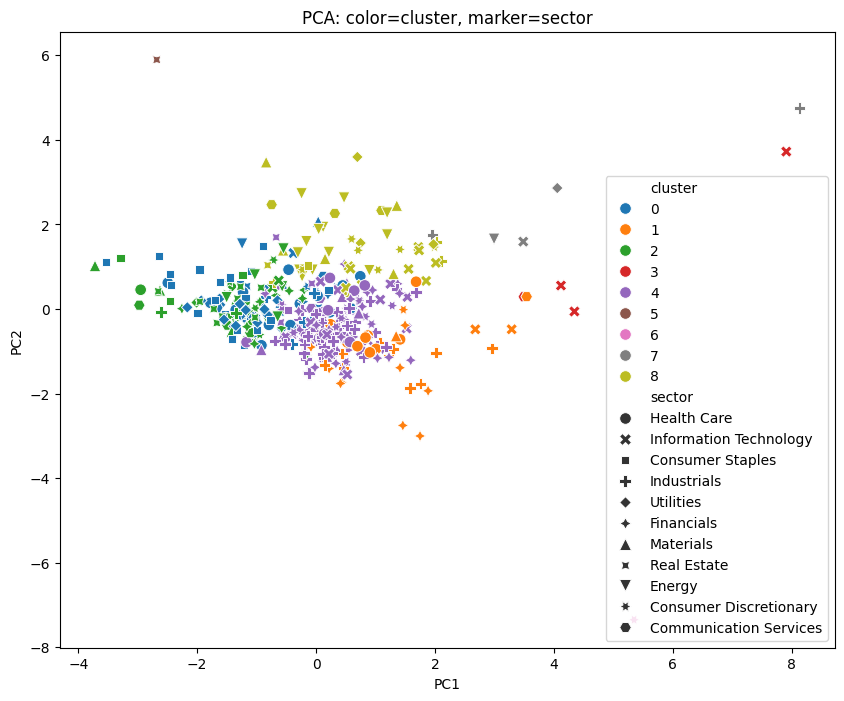

In [69]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=X, x="PC1", y="PC2",
    hue="cluster",            # Color represents cluster
    style="sector",           # Marker shape represents sector (note: legend may be long)
    palette="tab10", s=70
)
plt.title("PCA: color=cluster, marker=sector")
plt.show()







/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


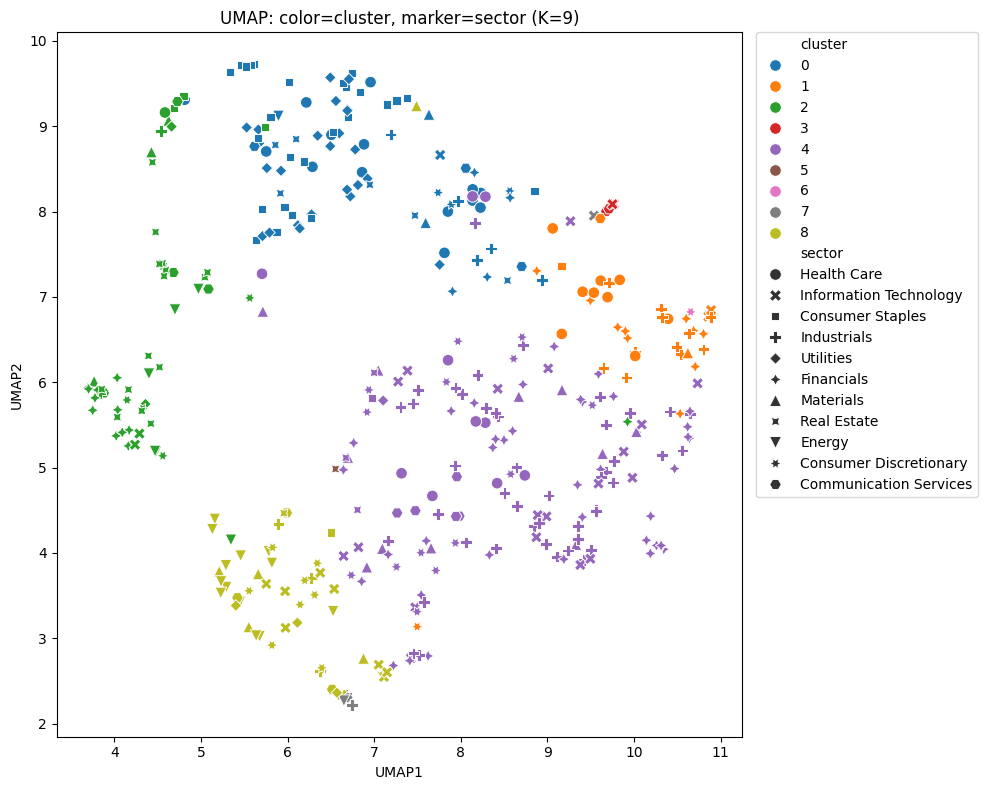

In [70]:
if 'HAS_UMAP' in globals() and HAS_UMAP:
    reducer = umap.UMAP(random_state=42)
    umap_coords = reducer.fit_transform(X_scaled)
    X["UMAP1"], X["UMAP2"] = umap_coords[:,0], umap_coords[:,1]

    plt.figure(figsize=(10,8))
    ax = sns.scatterplot(
        data=X, x="UMAP1", y="UMAP2",
        hue="cluster",          # Color represents cluster
        style="sector",         # Marker shape represents sector
        palette="tab10", s=70
    )
    plt.title(f"UMAP: color=cluster, marker=sector (K={best_k})")

    # Place legend outside the right side of the plot
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.show()


PCA Loadings:


,PC1,PC2
mean_return,0.590128,0.217212
volatility,0.308920,0.571537
corr_market,0.165853,-0.473344
pe,-0.060056,0.314679
eps,0.320031,-0.531735
market_cap,0.345286,0.080380
dividend_yield,-0.550963,0.117831



Absolute Loadings (sorted by PC1):


,PC1,PC2
mean_return,0.590128,0.217212
dividend_yield,0.550963,0.117831
market_cap,0.345286,0.080380
eps,0.320031,0.531735
volatility,0.308920,0.571537
corr_market,0.165853,0.473344
pe,0.060056,0.314679


<Figure size 800x500 with 0 Axes>

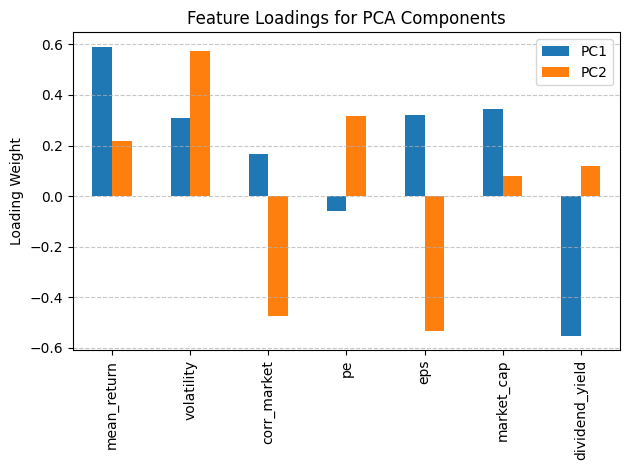

In [71]:
# Specify the feature columns used in PCA
feature_cols = ['mean_return', 'volatility', 'corr_market', 'pe', 'eps', 'market_cap', 'dividend_yield']

# Create the loadings DataFrame
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_cols
)

# Show the loadings
print("PCA Loadings:")
display(loadings)

# Sort by absolute weight (importance)
abs_loadings = loadings.abs().sort_values('PC1', ascending=False)
print("\nAbsolute Loadings (sorted by PC1):")
display(abs_loadings)

# Visualization (optional)
plt.figure(figsize=(8,5))
loadings[['PC1','PC2']].plot(kind='bar')
plt.title("Feature Loadings for PCA Components")
plt.ylabel("Loading Weight")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

UMAP Loadings (Pearson correlations):


,UMAP1,UMAP2
mean_return,0.315306,-0.340395
volatility,-0.219828,-0.599310
corr_market,0.308608,-0.522726
pe,-0.032085,-0.054193
eps,0.475313,0.049811
market_cap,0.212507,0.143408
dividend_yield,-0.663425,0.412903



Absolute Loadings (sorted by UMAP1):


,UMAP1,UMAP2
dividend_yield,0.663425,0.412903
eps,0.475313,0.049811
mean_return,0.315306,0.340395
corr_market,0.308608,0.522726
volatility,0.219828,0.599310
market_cap,0.212507,0.143408
pe,0.032085,0.054193


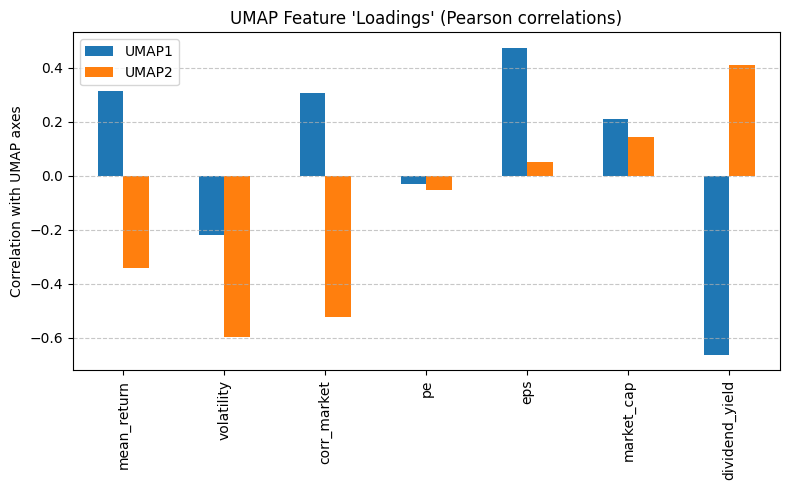

In [72]:
# === UMAP pseudo-loadings (Pearson correlations) ===
feature_cols = ['mean_return', 'volatility', 'corr_market',
                'pe', 'eps', 'market_cap', 'dividend_yield']

# Compute Pearson correlations between each feature and UMAP axes
umap_loadings = pd.DataFrame({
    'UMAP1': X[feature_cols].corrwith(X['UMAP1']),
    'UMAP2': X[feature_cols].corrwith(X['UMAP2'])
}, index=feature_cols)

# Display the loadings (same style as PCA output)
print("UMAP Loadings (Pearson correlations):")
display(umap_loadings)

# Sort by absolute value (importance for UMAP1)
abs_umap_loadings = umap_loadings.abs().sort_values('UMAP1', ascending=False)
print("\nAbsolute Loadings (sorted by UMAP1):")
display(abs_umap_loadings)

# --- Plot bar chart ---
ax = umap_loadings[['UMAP1','UMAP2']].plot(kind='bar', figsize=(8,5))
ax.set_title("UMAP Feature 'Loadings' (Pearson correlations)")
ax.set_ylabel("Correlation with UMAP axes")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
